In [5]:
import cv2
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
import math
import pandas as pd

In [6]:
ScaleTo = 70 
seed = 8  
path = 'C:/Users/WOO/Desktop/workspace/2025/test1/plant growth detection/train/*/*.png' 
files = glob(path)
trainImg = []
trainLabel = []
j = 1
num = len(files)

In [7]:

# Obtain images and resizing, obtain labels
for img in files:
    print(" Resizing Images : ",str(j) + "/" + str(num), end="\r")
    trainImg.append(cv2.resize(cv2.imread(img), (ScaleTo, ScaleTo)))  # Get image (with resizing)
    trainLabel.append(img.split('\\')[-2])  # Get image label (folder name)
    j += 1

In [17]:

trainImg = np.asarray(trainImg)  # Train images set
trainLabel = pd.DataFrame(trainLabel)  # Train labels set

In [18]:
print('trainlablel here is ', trainLabel)

trainlablel here is                  0
0     Black-grass
1     Black-grass
2     Black-grass
3     Black-grass
4     Black-grass
...           ...
4745   Sugar beet
4746   Sugar beet
4747   Sugar beet
4748   Sugar beet
4749   Sugar beet

[4750 rows x 1 columns]


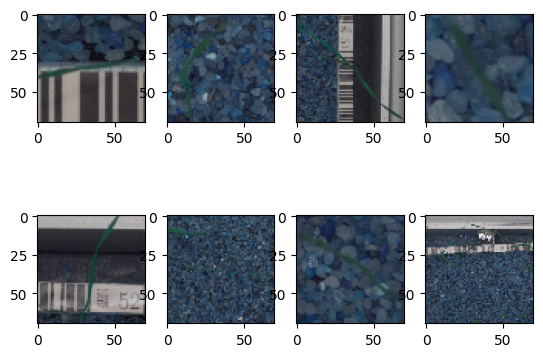

In [19]:
# Show some example images
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(trainImg[i])

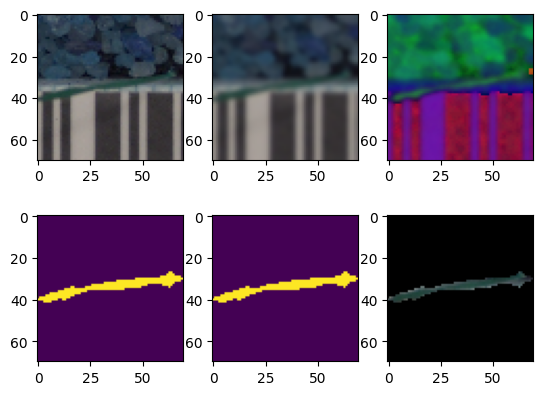

In [20]:
clearTrainImg = []
examples = []; getEx = True
for img in trainImg:
    # Use gaussian blur
    blurImg = cv2.GaussianBlur(img, (5, 5), 0)   
    
    # Convert to HSV image
    hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)  
    
    # Create mask (parameters - green color range)
    lower_green = (25, 40, 50)
    upper_green = (75, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Create bool mask
    bMask = mask > 0  
    
    # Apply the mask
    clear = np.zeros_like(img, np.uint8)  # Create empty image
    clear[bMask] = img[bMask]  # Apply boolean mask to the origin image
    
    clearTrainImg.append(clear)  # Append image without backgroung
    
    # Show examples
    if getEx:
        plt.subplot(2, 3, 1); plt.imshow(img)  # Show the original image
        plt.subplot(2, 3, 2); plt.imshow(blurImg)  # Blur image
        plt.subplot(2, 3, 3); plt.imshow(hsvImg)  # HSV image
        plt.subplot(2, 3, 4); plt.imshow(mask)  # Mask
        plt.subplot(2, 3, 5); plt.imshow(bMask)  # Boolean mask
        plt.subplot(2, 3, 6); plt.imshow(clear)  # Image without background
        getEx = False

clearTrainImg = np.asarray(clearTrainImg)

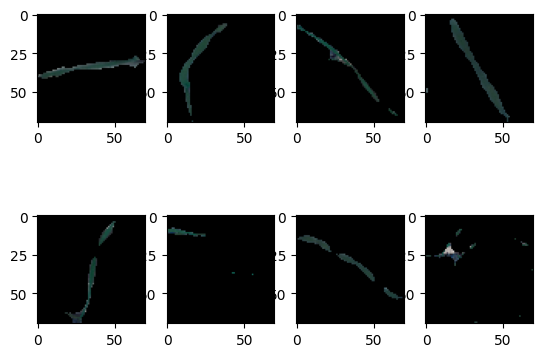

In [21]:
# Show sample result
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(clearTrainImg[i])

In [22]:
clearTrainImg = clearTrainImg / 255

Classes: ['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']
Number of classes: 12


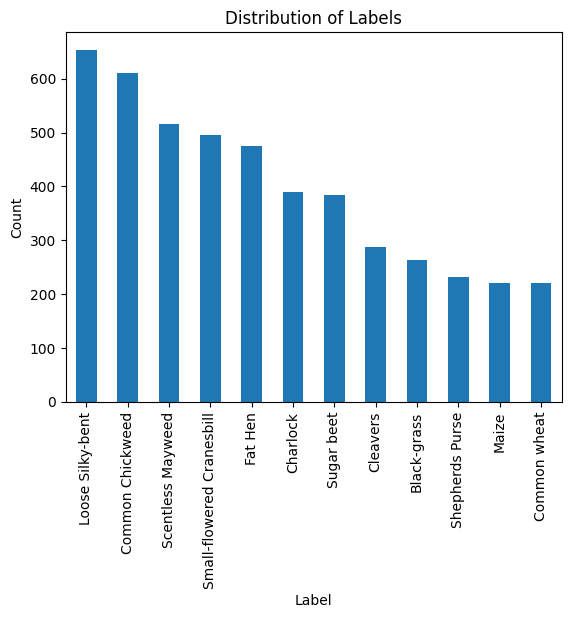

In [23]:
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd  # Required for label analysis

# Ensure trainLabel is a 1D list/array
if isinstance(trainLabel, pd.DataFrame):  # If it's a DataFrame
    trainLabel = trainLabel.iloc[:, 0].values  # Extract the first column and convert to NumPy array
elif isinstance(trainLabel, list):
    trainLabel = [str(label) for label in trainLabel]  # Ensure all elements are strings

# Encode labels and create classes
le = preprocessing.LabelEncoder()
le.fit(trainLabel)  # Fit on the entire label set
print("Classes: " + str(le.classes_))

# Transform labels
encodeTrainLabels = le.transform(trainLabel)

# Make labels categorical
clearTrainLabel = to_categorical(encodeTrainLabels)
num_classes = clearTrainLabel.shape[1]
print("Number of classes: " + str(num_classes))

# Plot of label type counts
trainLabel_series = pd.Series(trainLabel)  # Convert to Pandas Series
trainLabel_series.value_counts().plot(kind='bar')
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Distribution of Labels")
plt.show()


In [24]:
from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(clearTrainImg, clearTrainLabel, 
                                                test_size=0.1, random_state=seed, 
                                                stratify = clearTrainLabel)


In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=180,  # Randomly rotate images
        zoom_range=0.1,      # Randomly zoom images
        width_shift_range=0.1,  # Randomly shift images horizontally
        height_shift_range=0.1, # Randomly shift images vertically
        horizontal_flip=True,  # Randomly flip images horizontally
        vertical_flip=True     # Randomly flip images vertically
    )
datagen.fit(trainX)

In [26]:
import numpy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization


numpy.random.seed(seed)  # Fix seed

In [27]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(ScaleTo, ScaleTo, 3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

model.summary()

# compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

c:\Users\WOO\Desktop\workspace\2025\test1\plant growth detection\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 66, 66, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 66, 66, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 62, 62, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 31, 31, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 27, 27, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 27, 27, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 23, 23, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 11, 11, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 7, 7, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 3, 3, 256)      │     1,638,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 1, 1, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,320,396 (12.67 MB)

 Trainable params: 3,317,580 (12.66 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [15]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

# Learning rate reduction
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.4, 
                                            min_lr=0.00001)

# Checkpoints
filepath = "C:/Users/WOO/Desktop/workspace/2025/test1/plant growth detection/Checkpoint/weights.best_{epoch:02d}-{val_accuracy:.2f}.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', 
                             verbose=1, save_best_only=True, mode='max')

filepath = "C:/Users/WOO/Desktop/workspace/2025/test1/plant growth detection/Checkpoint/weights.last_auto4.keras"
checkpoint_all = ModelCheckpoint(filepath, monitor='val_accuracy', 
                                 verbose=1, save_best_only=False, mode='max')

# Callbacks list
callbacks_list = [checkpoint, learning_rate_reduction, checkpoint_all]


In [28]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']  # Ensure accuracy is being tracked
)

In [17]:
hist = model.fit(
    datagen.flow(trainX, trainY, batch_size=75), 
    epochs=35, 
    validation_data=(testX, testY), 
    steps_per_epoch=trainX.shape[0] // 75,  # Ensure proper number of steps
    callbacks=callbacks_list
)

Epoch 1/35


c:\Users\WOO\Desktop\workspace\2025\test1\plant growth detection\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.1859 - loss: 3.0896
Epoch 1: val_accuracy improved from -inf to 0.13684, saving model to C:/Users/WOO/Desktop/workspace/2025/test1/plant growth detection/Checkpoint/weights.best_01-0.14.keras

Epoch 1: saving model to C:/Users/WOO/Desktop/workspace/2025/test1/plant growth detection/Checkpoint/weights.last_auto4.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 482ms/step - accuracy: 0.1872 - loss: 3.0825 - val_accuracy: 0.1368 - val_loss: 11.3357 - learning_rate: 0.0010
Epoch 2/35
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.3888 - loss: 1.9661
Epoch 2: val_accuracy did not improve from 0.13684

Epoch 2: saving model to C:/Users/WOO/Desktop/workspace/2025/test1/plant growth detection/Checkpoint/weights.last_auto4.keras
57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 474ms/step - accuracy: 0.3891 - loss: 1.9648 - val_accuracy: 0.1368 - val_loss: 25.9069 - learning_rate: 0.0010
Epoch 3/35
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.4536 - los

In [18]:
# ## SAVE .npz file for later import if needed
# np.savez("C:/Users/WOO/Desktop/workspace/2025/test1/plant growth detection/Checkpoint/Data.npz", 
#          trainX=trainX, testX=testX, trainY=trainY, testY=testY)

# print("Data saved to 'Data.npz'")

Data saved to 'Data.npz'


### Evaluate Model

In [19]:
# model.load_weights("Checkpoint/weights.best_27-0.73.keras")


# trainX, testX, trainY, testY = train_test_split(clearTrainImg, clearTrainLabel, 
#                                                 test_size=0.1, random_state=seed, 
#                                                 stratify = clearTrainLabel)
# trainX = trainX
# testX = testX
# trainY = trainY
# testY = testY

# print(model.evaluate(trainX, trainY))  # Evaluate on train set
# print(model.evaluate(testX, testY))  # Evaluate on test set

134/134 ━━━━━━━━━━━━━━━━━━━━ 43s 322ms/step - accuracy: 0.7374 - loss: 0.7760
[0.7372416853904724, 0.7525146007537842]
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 319ms/step - accuracy: 0.7162 - loss: 0.8652
[0.8261771202087402, 0.7326315641403198]


In [29]:
model.load_weights("Checkpoint/weights.best_33-0.91.keras")

data = np.load("Data.npz")
d = dict(zip(("trainX","testX","trainY", "testY"), (data[k] for k in data)))
trainX = d['trainX']
testX = d['testX']
trainY = d['trainY']
testY = d['testY']

print(model.evaluate(trainX, trainY))  # Evaluate on train set
print(model.evaluate(testX, testY))  # Evaluate on test set

c:\Users\WOO\Desktop\workspace\2025\test1\plant growth detection\venv\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 70 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


134/134 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.9293 - loss: 0.1731
[0.18773253262043, 0.9235087633132935]
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9390 - loss: 0.1532
[0.17818614840507507, 0.9242105484008789]


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step


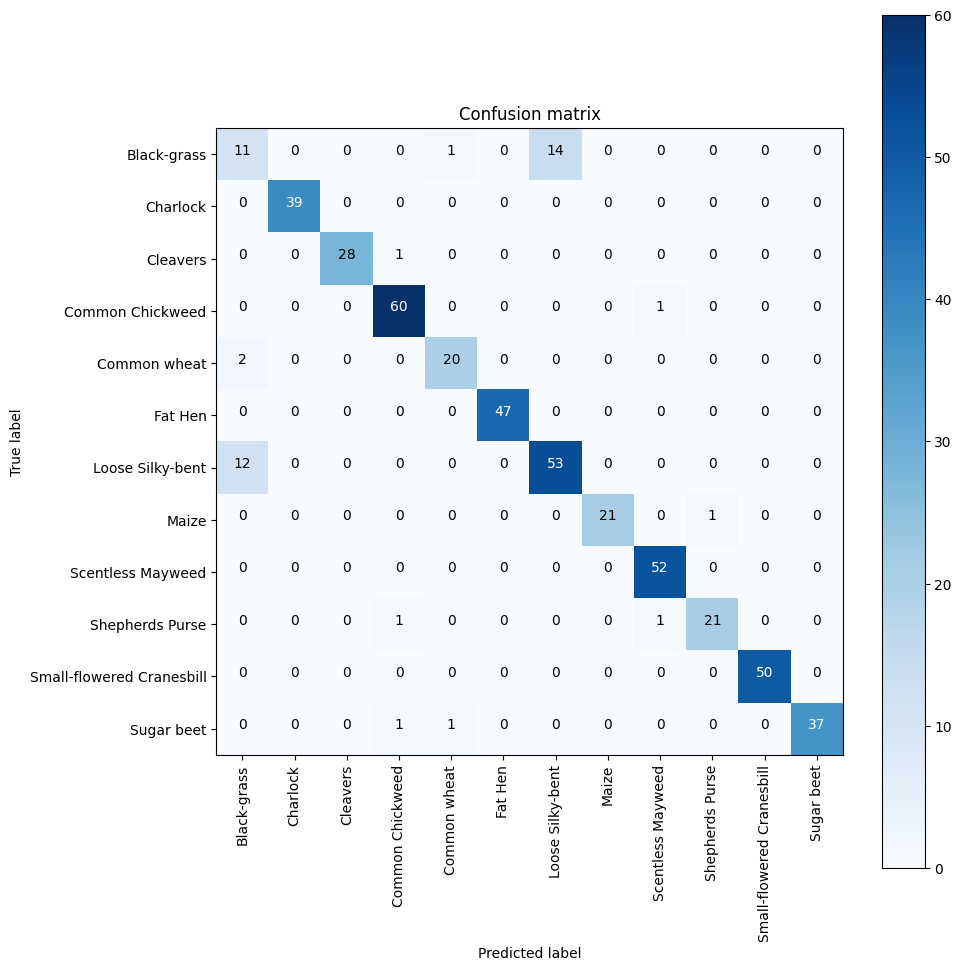

In [30]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
predY = model.predict(testX)
predYClasses = np.argmax(predY, axis = 1) 
trueY = np.argmax(testY, axis = 1) 

# confusion matrix
confusionMTX = confusion_matrix(trueY, predYClasses) 

# plot the confusion matrix
plot_confusion_matrix(confusionMTX, classes = le.classes_) 